# Hotel Booking Cancellation Prediction

In [1]:
from pathlib import Path

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score

import xgboost as xgb

from IPython.display import display
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from utils import convert_target_to_binary, reset_index, parse_xgboost_output, train_xgboost

from train import clean_and_standardize_data, prepare_data_for_model, train_model_and_evaluate

In [2]:
DATA_DIR = Path().parent / 'data'
FILE_PATH = DATA_DIR / 'hotel_reservations.csv'
TARGET = 'booking_status'
TARGET_VALUE = 'canceled'
KFOLD_SPLITS = 5
SEED = 1
N_JOBS = -1

In [3]:
df = pd.read_csv(FILE_PATH)
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
df.shape

(36275, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [6]:
numerical = [
    'no_of_adults',
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'lead_time',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'avg_price_per_room',
    'no_of_special_requests'
]

In [7]:
categorical = [
    'type_of_meal_plan',
    'required_car_parking_space',
    'room_type_reserved',
    'arrival_month',
    'arrival_date',
    'market_segment_type',
    'repeated_guest'
]

## Data Preparation

In [8]:
# Dropping unnecessary columns, standardizing the dataset, and handling missing values if present
df = clean_and_standardize_data(df, numerical_columns=numerical, categorical_columns=categorical,
                                columns_to_drop=['Booking_ID', 'arrival_year'])
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,meal_plan_1,0,room_type_1,224,10,2,offline,0,0,0,65.00,0,not_canceled
1,2,0,2,3,not_selected,0,room_type_1,5,11,6,online,0,0,0,106.68,1,not_canceled
2,1,0,2,1,meal_plan_1,0,room_type_1,1,2,28,online,0,0,0,60.00,0,canceled
3,2,0,0,2,meal_plan_1,0,room_type_1,211,5,20,online,0,0,0,100.00,0,canceled
4,2,0,1,1,not_selected,0,room_type_1,48,4,11,online,0,0,0,94.50,0,canceled


In [9]:
df['booking_status'].value_counts()

booking_status
not_canceled    24390
canceled        11885
Name: count, dtype: int64

In [10]:
df = convert_target_to_binary(df, target=TARGET, target_value=TARGET_VALUE)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,meal_plan_1,0,room_type_1,224,10,2,offline,0,0,0,65.00,0,0
1,2,0,2,3,not_selected,0,room_type_1,5,11,6,online,0,0,0,106.68,1,0
2,1,0,2,1,meal_plan_1,0,room_type_1,1,2,28,online,0,0,0,60.00,0,1
3,2,0,0,2,meal_plan_1,0,room_type_1,211,5,20,online,0,0,0,100.00,0,1
4,2,0,1,1,not_selected,0,room_type_1,48,4,11,online,0,0,0,94.50,0,1


In [11]:
# Splitting dataset into train/validation/test datasets with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

In [12]:
assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [13]:
len(df_train), len(df_val), len(df_test)

(21765, 7255, 7255)

## EDA

In [15]:
df_full_train = reset_index(df_full_train)
df_full_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,1,0,2,3,meal_plan_1,0,room_type_1,115,2,27,offline,0,0,0,76.00,0,0
1,2,0,2,1,meal_plan_2,0,room_type_1,131,8,15,offline,0,0,0,94.50,0,0
2,2,0,1,0,meal_plan_1,0,room_type_4,16,9,26,online,0,0,0,164.00,0,1
3,2,0,2,2,meal_plan_2,0,room_type_1,169,4,22,offline,0,0,0,106.00,0,1
4,1,0,1,0,meal_plan_1,1,room_type_1,5,12,5,complementary,1,2,8,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,2,0,2,1,meal_plan_1,0,room_type_1,66,11,12,online,0,0,0,105.33,1,1
29016,2,0,0,2,meal_plan_1,0,room_type_1,70,4,22,online,0,0,0,105.30,1,1
29017,1,0,1,2,meal_plan_1,0,room_type_1,24,6,6,online,0,0,0,120.00,0,1
29018,2,2,1,1,meal_plan_1,0,room_type_6,3,3,21,online,0,0,0,181.00,0,0


In [16]:
df_full_train[TARGET].mean()

0.3286354238456237

### Feature Importance: Cancellation rate and Risk ratio

In [17]:
global_cancellation_rate = df_full_train[TARGET].mean()
global_cancellation_rate

0.3286354238456237

In [18]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c)[TARGET].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_cancellation_rate
    df_group['risk'] = df_group['mean'] / global_cancellation_rate
    display(df_group)
    print('\n\n')

type_of_meal_plan


,mean,count,diff,risk
type_of_meal_plan,,,,
meal_plan_1,0.312264,22244,-0.016371,0.950184
meal_plan_2,0.459459,2664,0.130824,1.398083
meal_plan_3,0.200000,5,-0.128635,0.608577
not_selected,0.332603,4107,0.003967,1.012072





required_car_parking_space


,mean,count,diff,risk
required_car_parking_space,,,,
0,0.336060,28114,0.007425,1.022593
1,0.098234,906,-0.230401,0.298915





room_type_reserved


,mean,count,diff,risk
room_type_reserved,,,,
room_type_1,0.323350,22505,-0.005285,0.983918
room_type_2,0.333925,563,0.005290,1.016097
room_type_3,0.333333,6,0.004698,1.014295
room_type_4,0.341352,4822,0.012717,1.038696
room_type_5,0.275701,214,-0.052934,0.838926
room_type_6,0.425641,780,0.097006,1.295177
room_type_7,0.253846,130,-0.074789,0.772425





arrival_month


,mean,count,diff,risk
arrival_month,,,,
1,0.023428,811,-0.305208,0.071288
2,0.247619,1365,-0.081016,0.753476
3,0.302350,1872,-0.026285,0.920018
4,0.365621,2199,0.036985,1.112542
5,0.369534,2081,0.040898,1.124449
6,0.398093,2517,0.069458,1.211351
7,0.447582,2337,0.118947,1.361942
8,0.390069,3061,0.061433,1.186934
9,0.343227,3706,0.014592,1.044401





arrival_date


,mean,count,diff,risk
arrival_date,,,,
1,0.391211,933,0.062576,1.190411
2,0.236891,1068,-0.091744,0.720833
3,0.358314,854,0.029678,1.090308
4,0.359665,1076,0.031030,1.094421
5,0.291807,891,-0.036828,0.887935
6,0.351190,1008,0.022555,1.068632
7,0.334862,872,0.006227,1.018948
8,0.299270,959,-0.029365,0.910645
9,0.255763,911,-0.072873,0.778257





market_segment_type


,mean,count,diff,risk
market_segment_type,,,,
aviation,0.290000,100,-0.038635,0.882437
complementary,0.000000,305,-0.328635,0.000000
corporate,0.114127,1621,-0.214508,0.347276
offline,0.297832,8394,-0.030804,0.906268
online,0.366828,18600,0.038193,1.116216





repeated_guest


,mean,count,diff,risk
repeated_guest,,,,
0,0.336822,28279,0.008187,1.024912
1,0.016194,741,-0.312441,0.049277


### Feature Importance: Mutual information

In [19]:
def mutual_info_cancellation_score(series):
    return mutual_info_score(series, df_full_train[TARGET])

In [20]:
mi = df_full_train[categorical].apply(mutual_info_cancellation_score)
mi.sort_values(ascending=False)

arrival_month                 0.022822
market_segment_type           0.013890
repeated_guest                0.008502
required_car_parking_space    0.004723
arrival_date                  0.004275
type_of_meal_plan             0.003861
room_type_reserved            0.000769
dtype: float64

### Feature Importance: Correlation

In [21]:
df_full_train[numerical].corrwith(df_full_train[TARGET]).abs().sort_values(ascending=False)

lead_time                               0.438241
no_of_special_requests                  0.251734
avg_price_per_room                      0.146501
no_of_adults                            0.091589
no_of_week_nights                       0.091316
no_of_weekend_nights                    0.062028
no_of_previous_bookings_not_canceled    0.060505
no_of_children                          0.036285
no_of_previous_cancellations            0.035677
dtype: float64

From our analysis, it's clear that `lead_time`, `market_segment_type`, `avg_price_per_room`, and `no_of_special_requests` have the most significant influence on the target.

## Model Training

In [22]:
features = [*df_full_train.columns]
features.remove(TARGET)

### Logistic Regression: 5-Fold Cross-Validation

In [23]:
model_params = {
    'solver': 'liblinear',
    'C': 10,
    'max_iter': 1000,
    'random_state': SEED
}

In [24]:
model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, model_params=model_params, features=features,
                                                         target=TARGET, trainer='logistic_regression',
                                                         kfold_splits=KFOLD_SPLITS, seed=SEED)

In [25]:
round(evaluation_metrics['AUC'].mean, 3), round(evaluation_metrics['AUC'].std, 3)

(0.862, 0.003)

### Logistic Regression: Parameters Tuning

In [26]:
C = [0.01, 0.1, 0.5, 10]

auc_scores = []

for c in tqdm(C, desc='C'):

    model_params = {
        'solver': 'liblinear',
        'C': c,
        'max_iter': 1000,
        'random_state': SEED
    }

    model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, features=features, target=TARGET,
                                                             trainer='logistic_regression', kfold_splits=KFOLD_SPLITS,
                                                             seed=SEED, model_params=model_params)
    auc_scores.append(evaluation_metrics['AUC'].mean)

C:   0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
scores = [*zip(C, auc_scores)]
df_scores = pd.DataFrame(scores, columns=['C', 'AUC'])
df_scores

,C,AUC
0,0.01,0.859176
1,0.10,0.862301
2,0.50,0.862438
3,10.00,0.862376


Adjusting parameters does not notably impact the logistic regression model.

### Decision Tree: 5-Fold Cross-Validation

In [28]:
model_params = {
    'min_samples_leaf': 1,
    'random_state': SEED
}

In [29]:
model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, features=features, target=TARGET,
                                                         trainer='decision_tree', model_params=model_params,
                                                         kfold_splits=KFOLD_SPLITS, seed=SEED)

In [30]:
round(evaluation_metrics['AUC'].mean, 3), round(evaluation_metrics['AUC'].std, 3)

(0.848, 0.007)

### Decision Tree: Parameters Tuning

In [31]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

auc_scores = []

for d in tqdm(depths, desc='max_depth'):

    model_params = {
        'max_depth': d,
        'min_samples_leaf': 1,
        'random_state': SEED
    }

    model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, features=features, target=TARGET,
                                                             trainer='decision_tree', model_params=model_params,
                                                             kfold_splits=KFOLD_SPLITS, seed=SEED)
    auc_scores.append(evaluation_metrics['AUC'].mean)

max_depth:   0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
scores = [*zip(depths, auc_scores)]
df_scores = pd.DataFrame(scores, columns=['max_depth', 'AUC'])
df_scores.sort_values(by='AUC', ascending=False)

,max_depth,AUC
6,10.0,0.922690
7,15.0,0.901835
5,6.0,0.894426
4,5.0,0.881084
3,4.0,0.865469
8,20.0,0.865334
9,NaN,0.847828
2,3.0,0.822597
1,2.0,0.761797
0,1.0,0.676753


Text(0, 0.5, 'AUC')

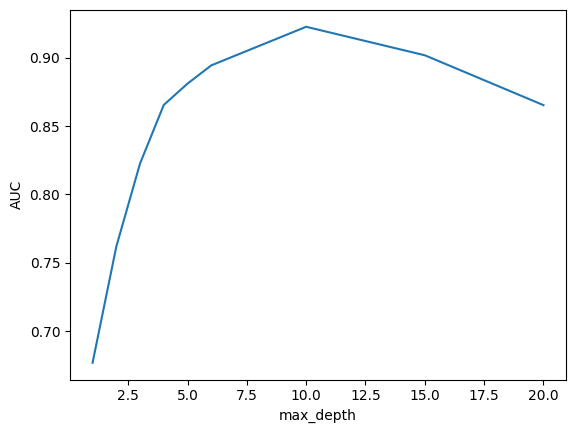

In [33]:
plt.plot(df_scores['max_depth'], df_scores['AUC'])
plt.xlabel('max_depth')
plt.ylabel('AUC')

The Decision Tree model delivers its best performance when the `max_depth` parameter is set to `10`.

In [34]:
min_samples_leaf = [1, 5, 10, 15, 20, 500, 100, 200]

auc_scores = []

for s in tqdm(min_samples_leaf, desc='min_samples_leaf'):

    model_params = {
        'max_depth': 10,
        'min_samples_leaf': s,
        'random_state': SEED
    }

    model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, features=features, target=TARGET,
                                                             trainer='decision_tree', model_params=model_params,
                                                             kfold_splits=KFOLD_SPLITS, seed=SEED)
    auc_scores.append(evaluation_metrics['AUC'].mean)

min_samples_leaf:   0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
scores = [*zip(min_samples_leaf, auc_scores)]
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'AUC'])
df_scores.sort_values(by='AUC', ascending=False)

,min_samples_leaf,AUC
2,10,0.925917
1,5,0.925229
4,20,0.923609
3,15,0.923463
0,1,0.922690
6,100,0.905032
7,200,0.894366
5,500,0.879692


The parameter `min_samples_leaf` doesn't notably affect the performance of the Decision Tree model.

### Random Forest: 5-Fold Cross-Validation

In [36]:
model_params = {
    'n_estimators': 100,
    'min_samples_leaf': 1,
    'random_state': SEED,
    'n_jobs': N_JOBS
}

In [37]:
model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, features=features, target=TARGET,
                                                         trainer='random_forest', model_params=model_params,
                                                         kfold_splits=KFOLD_SPLITS, seed=SEED)

In [38]:
round(evaluation_metrics['AUC'].mean, 3), round(evaluation_metrics['AUC'].std, 3)

(0.949, 0.003)

### Random Forest: Parameters Tuning

In [39]:
auc_scores = []

for d in tqdm([5, 10, 15], desc='max_depth'):
    for n in tqdm(range(10, 201, 10), desc='n_estimators', leave=False):
        model_params = {
            'max_depth': d,
            'n_estimators': n,
            'min_samples_leaf': 1,
            'random_state': SEED,
            'n_jobs': N_JOBS
        }

        model, dv, evaluation_metrics = train_model_and_evaluate(df_full_train, features=features, target=TARGET,
                                                                 trainer='random_forest', model_params=model_params,
                                                                 kfold_splits=KFOLD_SPLITS, seed=SEED)
        auc_scores.append((d, n, evaluation_metrics['AUC'].mean))

max_depth:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
columns = ['max_depth', 'n_estimators', 'AUC']
df_scores = pd.DataFrame(auc_scores, columns=columns)
df_scores.sort_values(by='AUC', ascending=False)

,max_depth,n_estimators,AUC
59,15,200,0.945453
57,15,180,0.945440
58,15,190,0.945402
56,15,170,0.945323
55,15,160,0.945265
54,15,150,0.945179
53,15,140,0.945005
52,15,130,0.944996
51,15,120,0.944995
49,15,100,0.944940


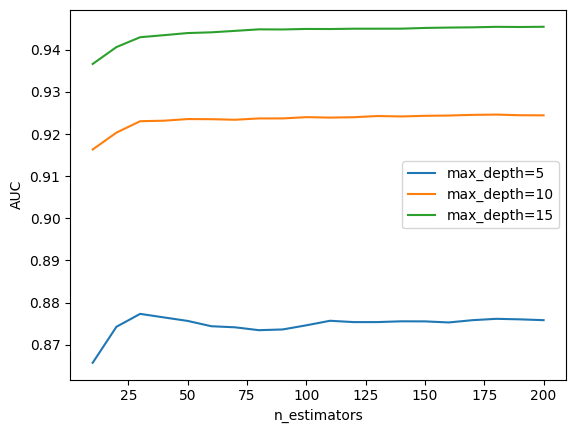

In [41]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset['n_estimators'], df_subset['AUC'],
             label='max_depth=%d' % d)

plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend()

The Random Forest model delivers its best performance when the `max_depth` parameter is set to `15`.

### XGBoost

In [43]:
X_train, X_val, y_train, y_val, dv = prepare_data_for_model(df_train, df_val, target=TARGET, features=features)

In [44]:
feature_names = [*dv.get_feature_names_out()]
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [45]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [46]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': SEED,
    'verbosity': 1,
}

model = train_xgboost(params=xgb_params, X=X_train, y=y_train, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [47]:
s = output.stdout

In [48]:
print(s[:200])

[0]	train-auc:0.89978	val-auc:0.89228
[5]	train-auc:0.92982	val-auc:0.91954
[10]	train-auc:0.94063	val-auc:0.92946
[15]	train-auc:0.94360	val-auc:0.93135
[20]	train-auc:0.94716	val-auc:0.93261
[25]	tr


In [49]:
df_score = parse_xgboost_output(output)

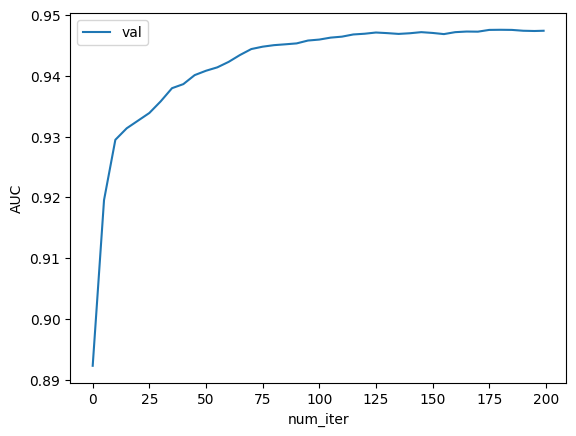

In [50]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.xlabel('num_iter')
plt.ylabel('AUC')
plt.legend()

### XGBoost parameter tuning

In [51]:
scores = {}

In [60]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': SEED,
    'verbosity': 1,
}

model = train_xgboost(params=xgb_params, X=X_train, y=y_train, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [61]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgboost_output(output)

In [62]:
scores.keys()

dict_keys(['eta=1.0', 'eta=0.5', 'eta=0.3', 'eta=0.1', 'eta=0.01'])

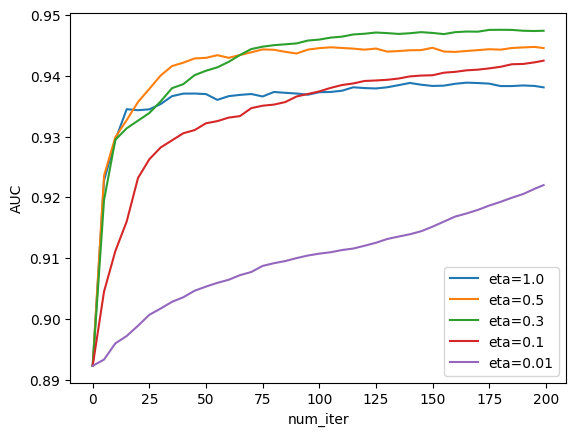

In [63]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.xlabel('num_iter')
plt.ylabel('AUC')
plt.legend()

The XGBoost model delivers its best performance when the `eta` parameter is set to `0.3`.

In [64]:
scores = {}

In [73]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 15,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': SEED,
    'verbosity': 1,
}

model = train_xgboost(params=xgb_params, X=X_train, y=y_train, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [74]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgboost_output(output)

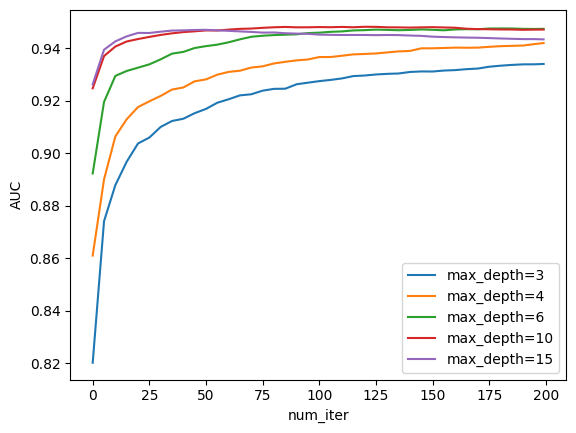

In [75]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.xlabel('num_iter')
plt.ylabel('AUC')
plt.legend()

The XGBoost model delivers its best performance when the `max_depth` parameter is set to `10`.

In [76]:
scores = {}

In [81]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': SEED,
    'verbosity': 1,
}

model = train_xgboost(params=xgb_params, X=X_train, y=y_train, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [82]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgboost_output(output)

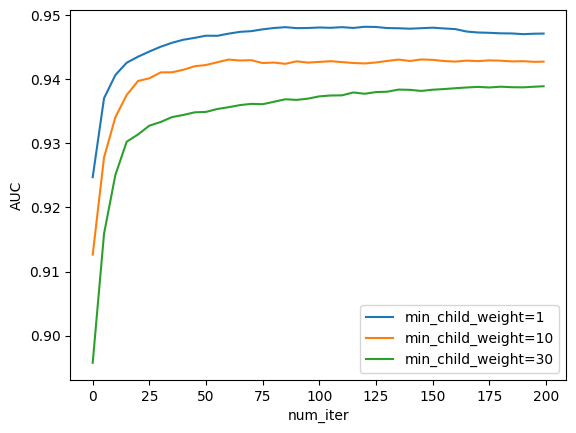

In [83]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.xlabel('num_iter')
plt.ylabel('AUC')
plt.legend()

The XGBoost model delivers its best performance when the `min_child_weight` parameter is set to `1`.

## Selecting the Final Model

### Logistic Regression

Irrespective of parameter adjustments, the logistic regression consistently exhibited the poorest performance in terms of results.

### Decision Tree

In [84]:
model_params = {
    'max_depth': 10,
    'min_samples_leaf': 1,
    'random_state': SEED
}

model, dv, evaluation_metrics = train_model_and_evaluate(df, features=features, target=TARGET, trainer='decision_tree',
                                                        model_params=model_params, kfold_splits=KFOLD_SPLITS, seed=SEED)

In [85]:
round(evaluation_metrics['AUC'].mean, 2)

0.93

### Random Forest

In [86]:
model_params = {
    'max_depth': 15,
    'n_estimators': 20,
    'min_samples_leaf': 1,
    'random_state': SEED,
    'n_jobs': N_JOBS
}

model, dv, evaluation_metrics = train_model_and_evaluate(df, features=features, target=TARGET, trainer='random_forest',
                                                        model_params=model_params, kfold_splits=KFOLD_SPLITS, seed=SEED)

In [87]:
round(evaluation_metrics['AUC'].mean, 3)

0.944

### XGBoost

In [88]:
model_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model, dv, evaluation_metrics = train_model_and_evaluate(df, features=features, target=TARGET, trainer='xgboost',
                                                        model_params=model_params, kfold_splits=KFOLD_SPLITS, seed=SEED)

In [89]:
round(evaluation_metrics['AUC'].mean, 3)

0.957

Observing the results, it's evident that XGBoost demonstrates the highest performance, achieving an AUC score of 0.95.